In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import pickle 
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample

%matplotlib inline

import alibi
from alibi.explainers import CounterfactualProto, Counterfactual
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe

import dice_ml

from warnings import simplefilter
simplefilter('ignore')

sys.path.append('../')

from src.training.caseci import *
from src.explainers import *

pd.set_option('display.max_columns', 500)

import tensorflow as tf
# tf.get_logger().setLevel(40)
# tf.compat.v1.disable_v2_behavior()
tf.__version__

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


'1.15.0'

In [2]:
case = CaseCI()

In [3]:
case.train_model()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 w

In [4]:
case.save_pipe(0, 'case')

In [5]:
case.print_metrics()

ROC AUC train :  0.6720031489092034 
 ROC AUC val :  0.64026294217547 
 ROC AUC test :  0.6434553534034837 

Precision test :  0.8490250147725035
Recall test :  0.7049636110883964


## PDP

1.	Общее количество сделок, заключенных с организацией на текущий день. С ростом количества открытых сделок на одного клиента вероятность отказа снижается на 10%. Формулировка задачи: «Проверь по своим клиентам соблюдение контактной политики. Старайся оперативно реагировать на потребности клиента». Выводим, если менее 5 открытых сделок на одного клиента
F_5 (PDP-plot)
2.	Доля завершенных звонков среди всех активностей за 3 дня. С ростом доли звонков среди всех активностей вероятность отказа растет на 1%. «Старайся поддерживать очный контакт с клиентами». Выводим, если более 0.9 доля звонков.
F_12 (PDP-plot)
3.	Среднее количество уникальных продуктов, предложенных клиенту за 3 дня. С ростом количества уникальных предложенных продуктов вероятность отказа растет на 2%. «Старайся точно идентифицировать потребности клиента и не предлагать новые продукты без необходимости». Выводим, если более 4 количество уникальных предложенных продуктов.
F_24 (PDP-plot)
4.	Количество уникальных продуктов, предложенных клиентам за 3 дня. С ростом числа уникальных предложенных продуктов у клиента вероятность отказа растет на 0.9%. «Старайся не предлагать большой ряд продуктов, уточни потребность клиента». Выводим, если более 15 уникальных предложенных клиентам продуктов.
F_18 (PDP-plot)
5.	Среднее количество завершенных встреч и завершенных звонков за 3 дня. Если совершать встречи, вероятность отказа снижается на 0.4%. «Старайся поддерживать очный контакт с клиентом». Выводим, если нет встреч и есть звонки за последние 3 дня.
F_15, F_72 (PDP-plot)



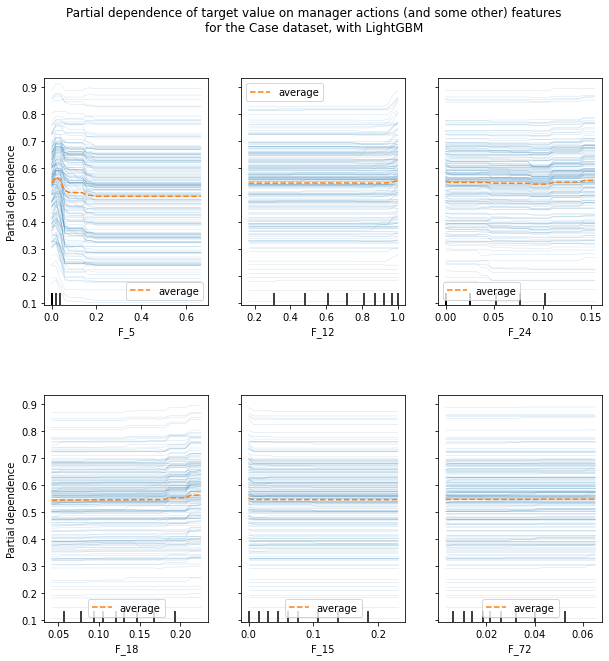

In [6]:
features = ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72'
           ]
title_fill = ['manager actions (and some other) features', 'Case', 'LightGBM']
plot_pdp_ice(case.grid_pipe_lgbm, case.X_train, features, title_fill)

## Feature importance

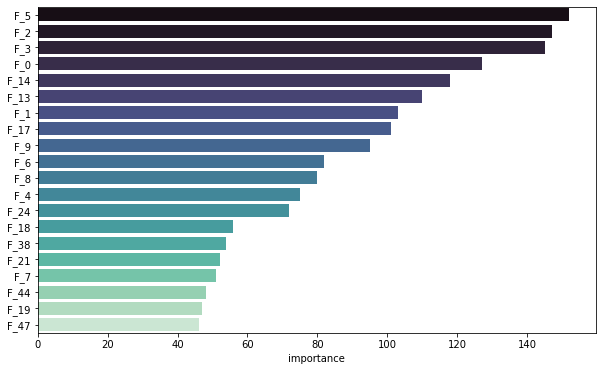

In [7]:
case.get_fimp(20)

## SHAP

In [93]:
import shap 
shap.initjs()
explainer = shap.TreeExplainer(case.grid_pipe_lgbm.best_estimator_)
shap_values = explainer.shap_values(case.X_test)

In [94]:
k = 76
shap.force_plot(explainer.expected_value[1], shap_values[1][k,:], case.X_test.iloc[k,:])

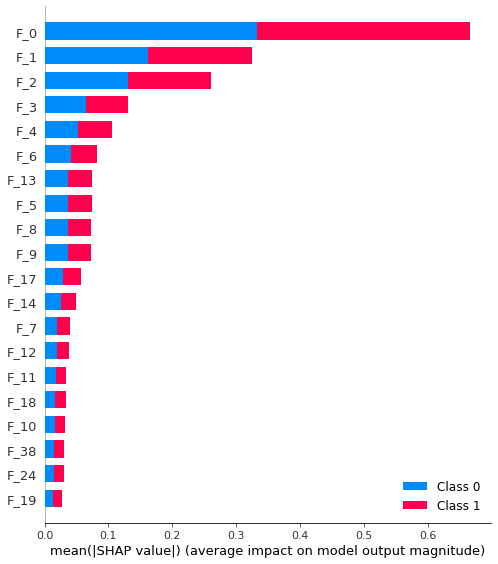

In [31]:
shap.summary_plot(shap_values, case.X_train)

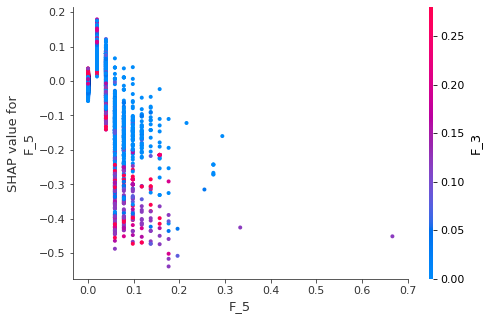

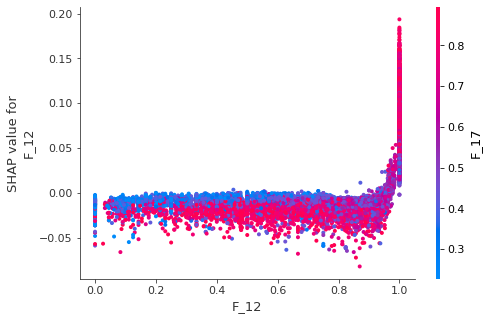

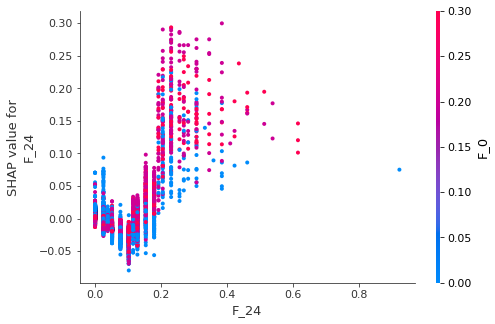

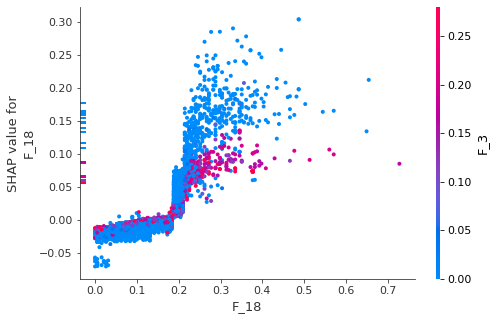

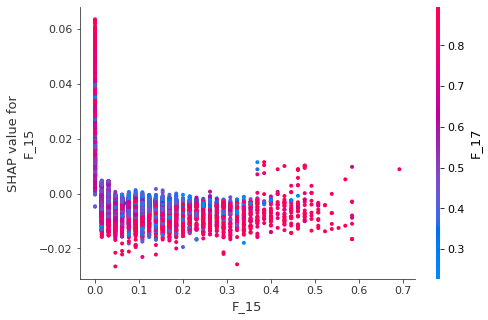

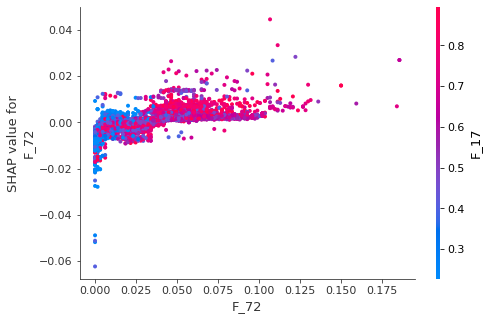

In [35]:
for name in ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72']:
    shap.dependence_plot(name, shap_values[1], case.X_test, display_features=case.X_test)

## Counterfactuals

In [89]:
not_closed_pred = (case.grid_pipe_lgbm.predict(case.X_test) == 1)
not_closed_pred = [i for i, x in enumerate(not_subscribed_pred) if x]

In [91]:
len(not_closed_pred)

10153

In [6]:
X_dice = case.data.drop(columns=['train_flag'])

In [7]:
d = dice_ml.Data(dataframe=X_dice, 
                 continuous_features=[c for c in case.data.columns 
                                      if c not in ['train_flag', 'target']], 
                 outcome_name='target')
m = dice_ml.Model(model=case.grid_pipe_lgbm, backend='sklearn')

In [8]:
exp = dice_ml.Dice(d,m)

In [75]:
features_to_vary = ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72']

In [67]:
# features_to_vary = case.names[:3].to_list()

['F_0', 'F_1', 'F_2']

In [101]:
query_instances = X_dice.iloc[[987]].drop(columns=['target'])

In [102]:
res = exp.generate_counterfactuals(query_instances, total_CFs=2, 
                                   desired_class="opposite", verbose=False,
                                  features_to_vary=features_to_vary
                                  )

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]

Only 1 (required 2)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


In [103]:
res.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,0.2,1.0,0.350031,0.04,0.444444,0.0,0.0,0.222222,0.004132,0.142857,0.0,0.210526,0.384615,0.209056,0.344441,0.123077,0.0,0.408798,0.089005,0.16,0.150538,0.340915,0.390244,0.0,0.025385,0.0,0.214,0.5,0.333333,0.045517,0.0,1.0,0.78,0.333333,0.0,0.0,0.135667,0.39,0.003722,0.011658,0.268293,0.142857,0.007874,0.004691,0.019608,0.333333,0.104747,0.099448,0.090923,0.071499,0.0,0.166667,0.0,0.777778,0.148515,0.375,0.499201,1.0,0.0,0.01219,0.0,0.11,0.490305,0.025641,0.0,0.0,0.055556,1.0,0.211711,0.756045,0.0,0.015528,0.007728,0.149446,0.0,0.0,0.0,1.0,0.0,0.004745,0.0,0.0,0.0,0.0,0.662129,1



Diverse Counterfactual set (new outcome: 0.0)


,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,-,-,-,-,-,0.6,-,-,0.0,-,-,-,-0.3,-,-,-0.8,-,-,-0.28539784,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,0.0,0.0,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-


In [86]:
res.cf_examples_list[0].final_cfs_df

,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,0.2,1.0,0.230178,0.0,0.0,0.9,0.5,0.555556,0.020661,0.089286,0.0,0.157895,-1.0,0.166338,0.040084,0.061538,0.0,0.453132,0.125654,0.0,0.064516,0.142812,0.146341,0.0,0.076923,0.0,0.176591,0.7,0.444444,0.121378,0.035928,1.0,0.35,0.111111,0.019868,0.0,0.365427,0.26,0.011278,0.009881,0.219512,0.214286,0.031496,0.043075,0.029412,0.094755,0.213517,0.024862,0.104989,0.022233,0.0,0.470588,0.25,0.352941,0.138614,0.0,0.551501,1.0,0.0,0.066267,0.0,0.0,0.387529,0.068376,0.0,0.628743,0.176471,0.639382,0.188829,0.416993,0.0,0.065217,0.063369,0.252474,0.0,0.0,0.008547,0.335329,0.25,0.031113,0.0,0.0,0.0,0.0,0.662129,0
1,0.2,1.0,0.230178,0.0,0.0,0.8,0.5,0.555556,0.020661,0.089286,0.0,0.157895,-0.0,0.166338,0.040084,0.061538,0.0,0.453132,0.125654,0.0,0.064516,0.142812,0.146341,0.0,0.076923,0.0,0.176591,0.7,0.444444,0.121378,0.035928,1.0,0.35,0.111111,0.019868,0.0,0.365427,0.26,0.011278,0.009881,0.219512,0.214286,0.031496,0.043075,0.029412,0.094755,0.213517,0.024862,0.104989,0.022233,0.0,0.470588,0.25,0.352941,0.138614,0.0,0.551501,1.0,0.0,0.066267,0.0,0.0,0.387529,0.068376,0.0,0.628743,0.176471,0.639382,0.188829,0.416993,0.0,0.065217,0.063369,0.252474,0.0,0.0,0.008547,0.335329,0.25,0.031113,0.0,0.0,0.0,0.0,0.662129,0
